# Shared iSNVs in SCAN transmission pairs

This notebook examines iSNVs in 6 SCAN transmission pairs comparing to random pairs.

Transmission pairs were identified by looking at all SCAN samples, finding samples from the same household, and eliminating household in which all samples had a symptom onset date within a day or two of each other.
If samples lacked a symptom onset date, they were not eliminated at this stage. For households with greater than 2 samples, symptom onset & the phylogenetic tree were used to construct transmission pairs. Note: It's possible for one sample to be part of more than one transmission pair because one person could have infected two individuals.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [3]:
def load_df(file):
    '''
    Loads metadata tsv as df.
    '''
    with open(file) as tfile:
        df = pd.read_csv(tfile, sep = '\t')
        if 'nwgc_id' in df.columns:
            df['nwgc_id'] = df.nwgc_id.astype('str')
        if 'position' and 'variant' in df.columns:
            df['snv'] = df['position'].astype('str').str.cat(df['variant'],sep="")
    return df

pairs_snvs = load_df('../results/snvs_scan_pairs.tsv')
pairs_meta = load_df('../results/metadata_scan_pairs.tsv')

## How many SNVs per sample?

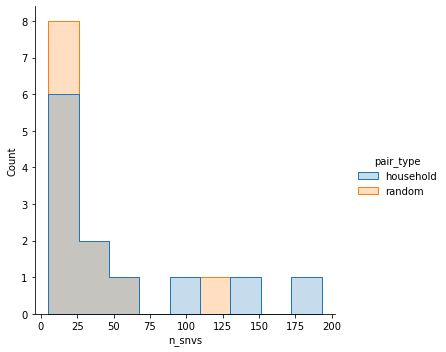

In [4]:
sns.displot(pairs_meta, x='n_snvs', hue = 'pair_type', element='step')

In [5]:
stats.ranksums(pairs_meta.loc[pairs_meta.pair_type == 'household', 'n_snvs'], pairs_meta.loc[pairs_meta.pair_type == 'random', 'n_snvs'])

RanksumsResult(statistic=0.46188021535170054, pvalue=0.6441672226837103)

iSNVs per sample in Household pairs

In [6]:
print(pairs_meta.loc[pairs_meta.pair_type == 'household', 'n_snvs'].min())
print(pairs_meta.loc[pairs_meta.pair_type == 'household', 'n_snvs'].max())
print(pairs_meta.loc[pairs_meta.pair_type == 'household', 'n_snvs'].median())

8
193
26.5


iSNVs per sample in Random pairs

In [7]:
print(pairs_meta.loc[pairs_meta.pair_type == 'random', 'n_snvs'].min())
print(pairs_meta.loc[pairs_meta.pair_type == 'random', 'n_snvs'].max())
print(pairs_meta.loc[pairs_meta.pair_type == 'random', 'n_snvs'].median())

5
119
16.5


## What is the distribution of iSNVs frequency?

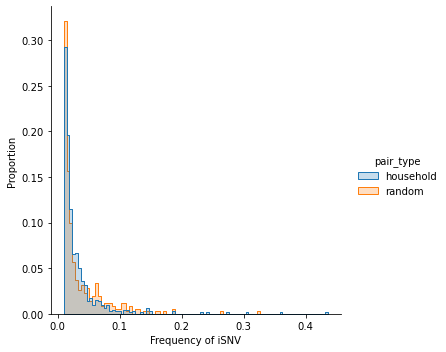

In [8]:
ax = sns.displot(pairs_snvs, x='frequency', hue='pair_type', stat='probability', common_norm=False, element='step')
ax.set(ylabel='Proportion', xlabel='Frequency of iSNV')

In [9]:
stats.ranksums(pairs_snvs.loc[pairs_snvs.pair_type == 'household', 'frequency'], pairs_snvs.loc[pairs_snvs.pair_type == 'random', 'frequency'])

RanksumsResult(statistic=-0.8283043911374233, pvalue=0.40749813665188417)

Frequency of iSNVs in Household pairs

In [10]:
print(pairs_snvs.loc[pairs_snvs.pair_type == 'household', 'frequency'].min())
print(pairs_snvs.loc[pairs_snvs.pair_type == 'household', 'frequency'].max())
print(pairs_snvs.loc[pairs_snvs.pair_type == 'household', 'frequency'].median())

0.010008963250672244
0.4356435643564357
0.019445878961340632


Frequency of iSNVs in Random pairs

In [11]:
print(pairs_snvs.loc[pairs_snvs.pair_type == 'random', 'frequency'].min())
print(pairs_snvs.loc[pairs_snvs.pair_type == 'random', 'frequency'].max())
print(pairs_snvs.loc[pairs_snvs.pair_type == 'random', 'frequency'].median())

0.010004001600640256
0.3217922606924644
0.019941132916089184


## What types of mutations are the variants?

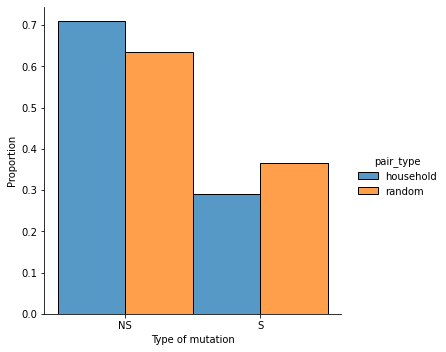

In [12]:
# recoding non-coding mutations as synonymous
pairs_snvs['mut_type'] = pairs_snvs.mut_type.replace(to_replace='NC', value='S')

ax = sns.displot(pairs_snvs, x='mut_type', hue='pair_type', stat='probability', common_norm=False, multiple='dodge')
ax.set(ylabel='Proportion', xlabel='Type of mutation')

In [13]:
def chi2(df):
    cross_tab = pd.crosstab(df['pair_type'], df['mut_type'])
    chi2, p, dof, ex = stats.chi2_contingency(cross_tab, correction = False)
    return p

chi2(pairs_snvs)

0.014893495804383162

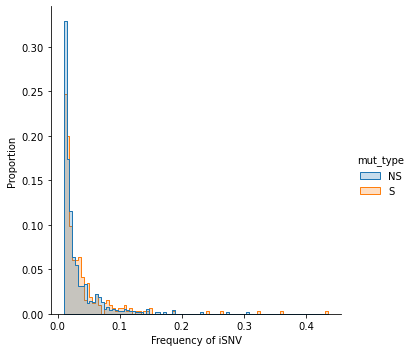

In [14]:
ax = sns.displot(pairs_snvs, x='frequency', hue='mut_type', stat='probability', common_norm=False, element='step')
ax.set(ylabel='Proportion', xlabel='Frequency of iSNV')

## Where in the genome are SNVs located?

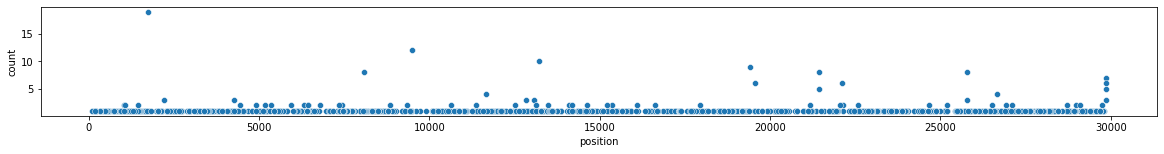

In [15]:
df_location = pd.value_counts(pairs_snvs.position).to_frame(name='count').rename_axis('position').reset_index()
plt.figure(figsize=(20,2))
ax = sns.scatterplot(data=df_location, x='position', y='count')


In [16]:
df_location.head(n=20)

,position,count
0,1730,19
1,9502,12
2,13225,10
3,19406,9
4,8084,8
5,21440,8
6,25777,8
7,29867,7
8,22104,6
9,29866,6


## Are iSNVs shared by transmission pairs?

<Figure size 576x288 with 0 Axes>

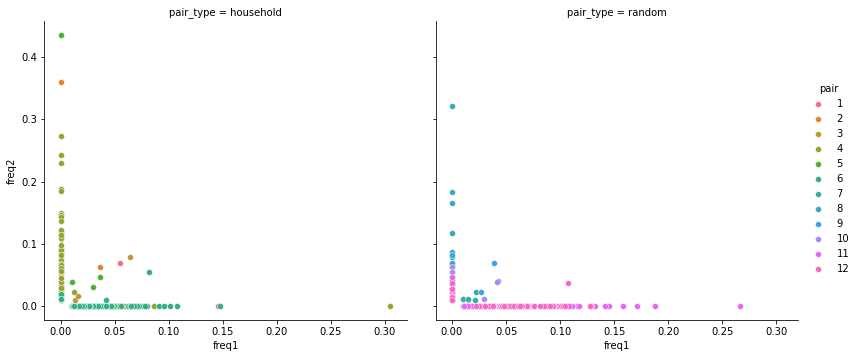

In [17]:
def pair_frequencies(df):
    df['pair'] = df.pair.astype('str')
    freq1 = []
    freq2 = []
    pair_types = []
    pairs = []
    for pair in df.pair.unique():
        samples = df.loc[df.pair==pair, 'nwgc_id'].unique()
        snvs = df.loc[df.nwgc_id.isin(samples), 'snv'].unique()
        df1 = df[df.nwgc_id == samples[0]]
        df2 = df[df.nwgc_id == samples[1]]
        for snv in snvs:
            if snv in df1.snv.values: 
                freq1.append(df1.loc[df1.snv==snv, 'frequency'].values[0])
            else:
                freq1.append(0)
            if snv in df2.snv.values:
                freq2.append(df2.loc[df2.snv==snv, 'frequency'].values[0])
            else:
                freq2.append(0)
            pairs.append(pair)
            pair_types.append(df1['pair_type'].unique()[0])
    frequencies = pd.DataFrame({'freq1':freq1, 'freq2':freq2, 'pair':pairs, 'pair_type':pair_types})
    return frequencies
        
frequencies = pair_frequencies(pairs_snvs)
plt.figure(figsize=(8,4))
g = sns.FacetGrid(frequencies, col='pair_type', hue='pair')
g.map(sns.scatterplot,'freq1','freq2')
g.fig.set_figwidth(12)
g.fig.set_figheight(6)
g.add_legend()


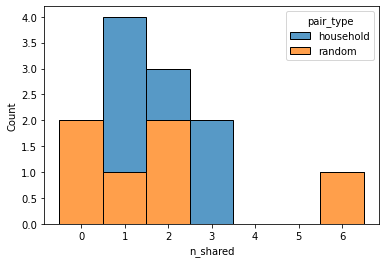

In [18]:
def shared_by_pair(df):
    pairs = []
    pair_types = []
    shared_snvs = []
    for pair in df.pair.unique():
        samples = df.loc[df.pair==pair, 'nwgc_id'].unique()
        s1 = set(df.loc[df.nwgc_id==samples[0], 'snv'])
        s2 = set(df.loc[df.nwgc_id==samples[1], 'snv'])
        shared = s1.intersection(s2)
        n_shared = len(shared)
        pair_type = df.loc[df.pair == pair, 'pair_type'].unique()[0]
        pairs.append(pair)
        pair_types.append(pair_type) 
        shared_snvs.append(n_shared)
    shared_pairs = pd.DataFrame({'pair' : pairs, 'n_shared' : shared_snvs, 'pair_type' : pair_types})
    return shared_pairs

shared_pairs = shared_by_pair(pairs_snvs)
fig, ax = plt.subplots()
sns.histplot(shared_pairs, x='n_shared', hue = 'pair_type', multiple='stack', ax =ax)
ax.set_xticks(np.arange(min(shared_pairs['n_shared'])+0.5, max(shared_pairs['n_shared'])+0.5, 1.0))
ax.set_xticklabels(range(7))
plt.show()
        

        

In [19]:
stats.ranksums(shared_pairs.loc[shared_pairs.pair_type == 'household', 'n_shared'], shared_pairs.loc[shared_pairs.pair_type == 'random', 'n_shared'])

RanksumsResult(statistic=0.560448538317805, pvalue=0.5751735319201967)